<a href="https://colab.research.google.com/github/ordepzero/generative_ai/blob/main/Basic_Generative_Architecture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import the libraries
import torch, pdb
from torch.utils.data import DataLoader
from torch import nn
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

In [2]:
# visualization function - reshape the size of the tensor
def show(tensor, ch=1, size=(28,28), num=16):
  data = tensor.detach().cpu().view(-1, ch, *size)
  grid = make_grid(data[:num], nrow=4).permute(1,2,0)
  plt.imshow(grid)
  plt.show()

In [3]:
# setup of the main parameters and hyperparameters
epochs = 300
cur_step = 0
info_step = 300
mean_gen_loss = 0
mean_disc_loss = 0

z_dim = 64
lr = 0.00001

# BCELoss: Creates a criterion that measures the Binary Cross Entropy between the target and the input probabilities
# BCEWithLogitsLoss: This loss combines a Sigmoid layer and the BCELoss in one single class. This version is more numerically stable
# than using a plain Sigmoid followed by a BCELoss as, by combining the operations into one layer, we take advantage
# of the log-sum-exp trick for numerical stability.
loss_func = nn.BCEWithLogitsLoss()


# How many images are we going to process at onde in the GPU in parallel?
bs = 128

# Librarie for parallel processing from Nvidia.
device = 'cuda'

# Structure that is gona hold our training data
# It give a batch of training data
# transform=transforms.ToTensor(): after download the data apply the tansform function
dataloader = DataLoader(MNIST('.', download=True, transform=transforms.ToTensor()), shuffle=True, batch_size=bs)


# number of steps = 60000 / 128 = 468.76

100%|██████████| 9912422/9912422 [05:03<00:00, 32713.98it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 445889.51it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 1648877/1648877 [00:00<00:00, 3063829.93it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 4470905.60it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [4]:
# declare our models


# generator
def genBlock(inp, out):
  # The value a Sequential provides over manually calling a sequence of
  # modules is that it allows treating the whole container as a single module,
  # such that performing a transformation on the Sequential applies to each of
  # the modules it stores (which are each a registered submodule of the Sequential).
  return nn.Sequential(
      nn.Linear(inp, out),
      nn.BatchNorm1d(out),
      nn.ReLU(inplace=True)
  )

class Generator(nn.Module):
  def __init__(self, z_dim=64, i_dim=784, h_dim=128):
    super().__init__()
    self.gen = nn.Sequential(
        genBlock(z_dim, h_dim), # 64, 128
        genBlock(h_dim, h_dim*2), # 128, 256
        genBlock(h_dim*2, h_dim*4), # 256, 512
        genBlock(h_dim*4, h_dim*8), # 512, 1024
        nn.Linear(h_dim*8, i_dim), # 1024, 784 (28x28)
        nn.Sigmoid(),
    )

  def forward(self, noise):
      return self.gen(noise)

def gen_noise(number, z_dim):
  return torch.randn(number, z_dim).to(device)

In [5]:
### Discriminator

def discBlock(inp, out):
  return nn.Sequential(
      nn.Linear(inp, out),
      nn.LeakyReLU(0.2)
  )

class Discriminator(nn.Module):
  def __init__(self, i_dim=784, h_dim=256):
    super().__init__()
    self.disc=nn.Sequential(
        discBlock(i_dim, h_dim*4), # 784, 1024
        discBlock(h_dim*4, h_dim*2), # 1024, 512
        discBlock(h_dim*2, h_dim), # 512, 256
        nn.Linear(h_dim, 1) # 256 ,1
    )

  def forward(self, image):
    return self.disc(image)

In [6]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)

In [7]:
gen

Generator(
  (gen): Sequential(
    (0): Sequential(
      (0): Linear(in_features=64, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Linear(in_features=128, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): Linear(in_features=256, out_features=512, bias=True)
      (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): Linear(in_features=512, out_features=1024, bias=True)
      (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (4): Linear(in_features=1024, out_features=784, bias=True)
    (5): Sigmoid()
  )
)

In [8]:
disc = Discriminator().to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

In [9]:
disc

Discriminator(
  (disc): Sequential(
    (0): Sequential(
      (0): Linear(in_features=784, out_features=1024, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (1): Sequential(
      (0): Linear(in_features=1024, out_features=512, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (2): Sequential(
      (0): Linear(in_features=512, out_features=256, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (3): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [10]:
x, y =next(iter(dataloader))
print(x.shape, y.shape)
print(y[:10])

torch.Size([128, 1, 28, 28]) torch.Size([128])
tensor([4, 9, 9, 8, 7, 4, 3, 7, 2, 0])


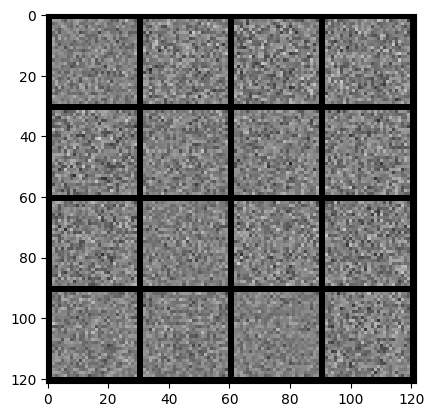

In [11]:
# begining of the noise image

noise = gen_noise(bs, z_dim)
fake = gen(noise)
show(fake)

In [12]:
# calculating the loss

def calc_gen_loss(loss_func, gen, disc, number, z_dim):
  '''
  number represente the number of elements to process, by default 128 images for patch
  '''
  noise = gen_noise(number, z_dim)
  fake = gen(noise)
  pred = disc(fake)
  targets = torch.ones_like(pred)
  gen_loss = loss_func(pred, targets)

  return gen_loss

def calc_disc_loss(loss_func, gen, disc, number, real, z_dim):
  noise = gen_noise(number, z_dim)
  fake = gen(noise)
  disc_fake = disc(fake.detach()) # optimize the parameters just for discriminator
  disc_fake_targets = torch.zeros_like(disc_fake)
  disc_fake_loss = loss_func(disc_fake, disc_fake_targets)

  disc_real = disc(real)
  disc_real_targets = torch.ones_like(disc_real)
  disc_real_loss = loss_func(disc_real, disc_real_targets)

  disc_loss = (disc_fake_loss + disc_real_loss)/2

  return disc_loss